In [31]:
import pandas as pd

# Load the provided Excel file
data = pd.read_excel('AAA_2023_DID_PSM_mod.xlsx', sheet_name='post (2)')

# Display the first few rows of the dataframe to get an overview
data.head()

,operation date,male,dead,age,height,weight,BMI,EVAR,TIVA,Block,...,mass_pre,post3_u_r,post3_u_l,post3_l_r,post3_l_l,post4_u_r,post4_u_l,post4_l_r,post4_l_l,mass_post
0,2012-03-16,1,0,71,156.0,71.15,29.24,0,0,0,...,1044.97,16.54,12.54,14.76,22.86,16.54,12.54,14.76,22.86,1093.99
1,2012-07-12,1,0,66,167.8,78.50,27.88,1,1,0,...,1580.73,12.61,15.35,20.00,22.96,13.61,17.05,18.81,18.82,1177.45
2,2012-07-26,1,0,68,170.6,70.40,24.19,0,0,0,...,1328.05,16.98,18.50,20.26,21.38,15.73,14.10,19.12,20.48,1329.33
3,2012-08-30,1,1,80,162.2,49.00,18.62,0,1,0,...,509.63,5.61,9.34,15.91,17.79,7.61,7.96,15.54,16.48,501.18
4,2012-09-06,0,0,66,157.5,47.00,18.95,0,0,0,...,682.15,9.41,12.16,18.73,20.12,7.91,10.85,21.07,20.12,805.36


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   operation date       50 non-null     datetime64[ns]
 1   male                 50 non-null     int64         
 2   dead                 50 non-null     int64         
 3   age                  50 non-null     int64         
 4   height               50 non-null     float64       
 5   weight               50 non-null     float64       
 6   BMI                  50 non-null     float64       
 7   EVAR                 50 non-null     int64         
 8   TIVA                 50 non-null     int64         
 9   Block                50 non-null     int64         
 10  room duration        50 non-null     int64         
 11  anesthesia duration  50 non-null     int64         
 12  operation duration   50 non-null     int64         
 13  HT                   50 non-null     

In [35]:
from scipy.stats import shapiro

# 数値データ列を抽出
numeric_columns = data.select_dtypes(include='number').columns

# 各数値列の正規性を検証
results = {}
for column in numeric_columns:
    stat, p_value = shapiro(data[column].dropna())  # NaNを除外して正規性検定
    results[column] = {'Statistic': stat, 'p-value': p_value}

# 結果を表示
results_df = pd.DataFrame(results).T
results_df['Normality'] = results_df['p-value'] > 0.05  # p値が0.05より大きい場合、正規性があると判断

print("各数値列の正規性検定結果:\n", results_df)


各数値列の正規性検定結果:
                      Statistic       p-value  Normality
male                  0.441237  1.573239e-12      False
dead                  0.125428  1.127410e-15      False
age                   0.982333  6.536110e-01       True
height                0.936053  9.432799e-03      False
weight                0.949181  3.157641e-02      False
BMI                   0.976179  4.043068e-01       True
EVAR                  0.622127  4.209901e-10      False
TIVA                  0.607700  2.538413e-10      False
Block                 0.125428  1.127410e-15      False
room duration         0.900216  4.884272e-04      False
anesthesia duration   0.894241  3.118158e-04      False
operation duration    0.902327  5.739942e-04      False
HT                    0.562359  5.593846e-11      False
DM                    0.511323  1.153056e-11      False
DL                    0.615555  3.338047e-10      False
smoke                 0.511323  1.153056e-11      False
OMI                   0.467097  3

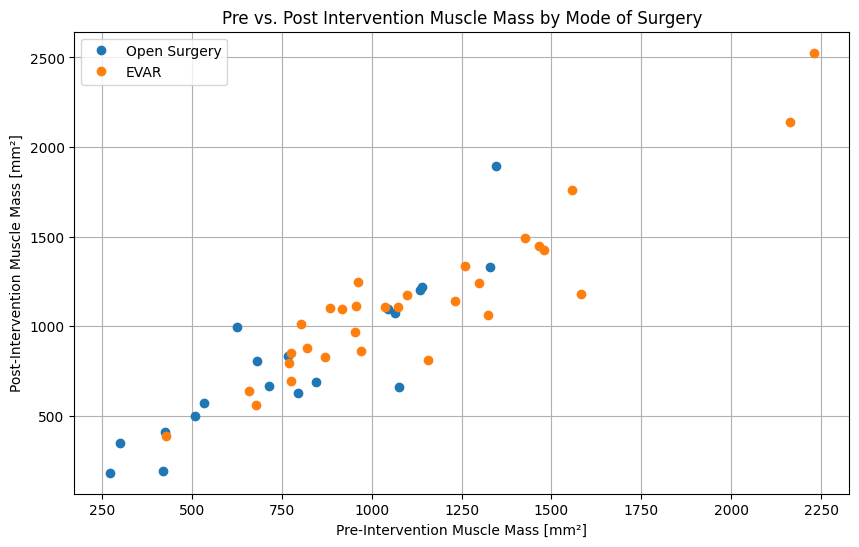

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mass_change   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.1104
Date:                Sun, 06 Oct 2024   Prob (F-statistic):              0.741
Time:                        21:11:39   Log-Likelihood:                 10.909
No. Observations:                  49   AIC:                            -17.82
Df Residuals:                      47   BIC:                            -14.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
treatment            0.0096      0.029      0.332      0.741      -0.049       0.068
post_period          0.9946      0.045     21.924      0.000       0.903       1.086
treatment_x_post     0.0096      0.029      0.332      0.741      -0.049       0.068
==============================================================================
Omnibus:                        3.998   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.135   Jarque-Bera (JB):                4.106
Skew:                           0.068   Prob(JB):                        0.128
Kurtosis:                       4.412   Cond. No.                     2.64e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.4e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

post_data = data.copy()
post_data = post_data[post_data['mass_post']!=0]
# Using 'mass_pre' as pre-intervention, 'mass_post' as post-intervention, and 'EVAR' as the intervention indicator for DID analysis

# Preparing the data for DID analysis
post_data['treatment'] = post_data['EVAR']
post_data['post_period'] = (post_data['mass_post'].notnull()).astype(int)
post_data['mass_change'] = post_data['mass_post'] / post_data['mass_pre']

# Creating interaction term for DID analysis
post_data['treatment_x_post'] = post_data['treatment'] * post_data['post_period']

# Defining the model
did_model = sm.OLS(post_data['mass_change'], sm.add_constant(post_data[['treatment', 'post_period', 'treatment_x_post']]))
did_results = did_model.fit()

# Plotting
plt.figure(figsize=(10, 6))
groups = post_data.groupby('treatment')
for name, group in groups:
    if name == 0:
        label = 'Open Surgery'
    else:
        label = 'EVAR'
    plt.plot(group['mass_pre'], group['mass_post'], marker='o', linestyle='', label=label)
plt.xlabel('Pre-Intervention Muscle Mass [mm\u00B2]')
plt.ylabel('Post-Intervention Muscle Mass [mm\u00B2]')
plt.legend()
plt.title('Pre vs. Post Intervention Muscle Mass by Mode of Surgery')
plt.grid(True)
plt.show()

# Displaying the summary of the model
did_results.summary()

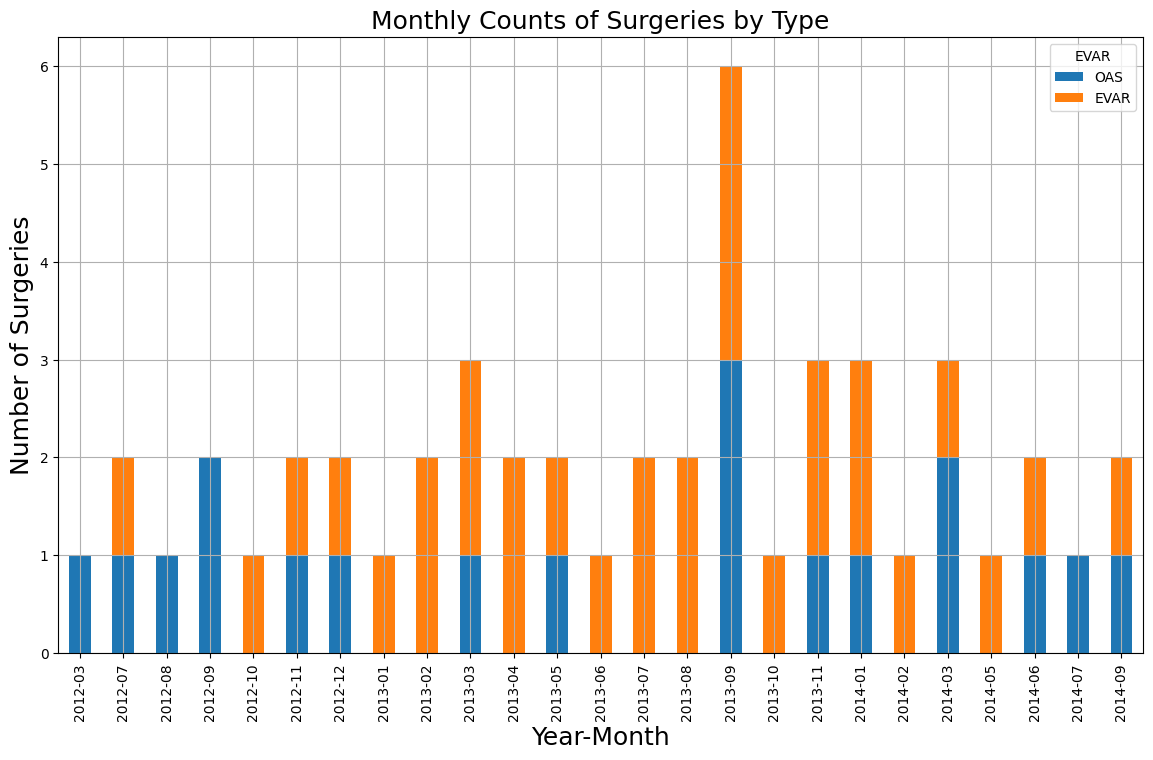

In [84]:
# 'operation date'をdatetime型に変換
post_data['operation date'] = pd.to_datetime(post_data['operation date'])

# 月ごとの集計
post_data['year_month'] = post_data['operation date'].dt.to_period('M')

# EVAR=1とEVAR=0の件数を集計
monthly_counts = post_data.groupby(['year_month', 'EVAR']).size().unstack(fill_value=0)

# プロットの作成
monthly_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.xlabel('Year-Month', fontsize=18)
plt.ylabel('Number of Surgeries', fontsize=18)
plt.title('Monthly Counts of Surgeries by Type', fontsize=18)
plt.legend(title='EVAR', labels=['OAS', 'EVAR'])
plt.grid(True)
plt.show()

C:\Users\bougt\AppData\Local\Temp\ipykernel_49256\2798422678.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'95% CI: [{conf_int[0][2]:.2f}, {conf_int[1][2]:.2f}]\n'


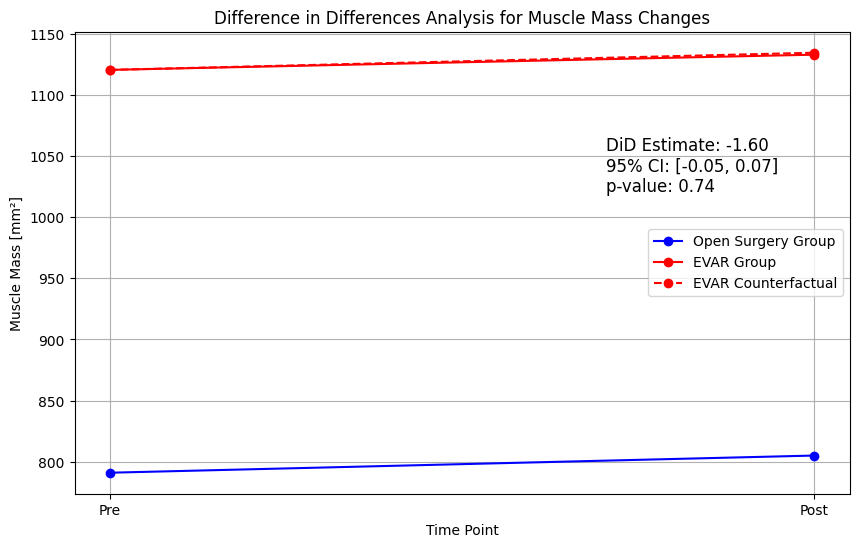

In [39]:
# Calculate group averages for pre and post intervention
control_pre = post_data[post_data['treatment'] == 0]['mass_pre'].mean()
control_post = post_data[post_data['treatment'] == 0]['mass_post'].mean()
treatment_pre = post_data[post_data['treatment'] == 1]['mass_pre'].mean()
treatment_post = post_data[post_data['treatment'] == 1]['mass_post'].mean()

# Calculate the differences for control and treatment groups
control_diff = control_post - control_pre
treatment_diff = treatment_post - treatment_pre

# Calculate the Difference in Differences estimate
did_estimate = treatment_diff - control_diff

# Get the coefficients from the DID model
coefficients = did_results.params
conf_int = did_results.conf_int()
t_stat = did_results.tvalues['treatment_x_post']
p_value = did_results.pvalues['treatment_x_post']

# Calculate the counterfactual for the treatment group (what would have happened without treatment)
counterfactual_treatment_post = treatment_pre + control_diff

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the actual averages
plt.plot(['Pre', 'Post'], [control_pre, control_post], 'o-', label='Open Surgery Group', color='blue')
plt.plot(['Pre', 'Post'], [treatment_pre, treatment_post], 'o-', label='EVAR Group', color='red')

# Plot the counterfactual line
plt.plot(['Pre', 'Post'], [treatment_pre, counterfactual_treatment_post], 'o--', label='EVAR Counterfactual', color='red')

annotation_text = (f'DiD Estimate: {did_estimate:.2f}\n'
                   f'95% CI: [{conf_int[0][2]:.2f}, {conf_int[1][2]:.2f}]\n'
                   f'p-value: {p_value:.2f}')
plt.annotate(annotation_text, xy=(1, counterfactual_treatment_post), xycoords='data',
             xytext=(-150, -100), textcoords='offset points', fontsize=12)


plt.xlabel('Time Point')
plt.ylabel('Muscle Mass [mm\u00B2]')
plt.title('Difference in Differences Analysis for Muscle Mass Changes')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# ↑EVAR有利だが有意ではない

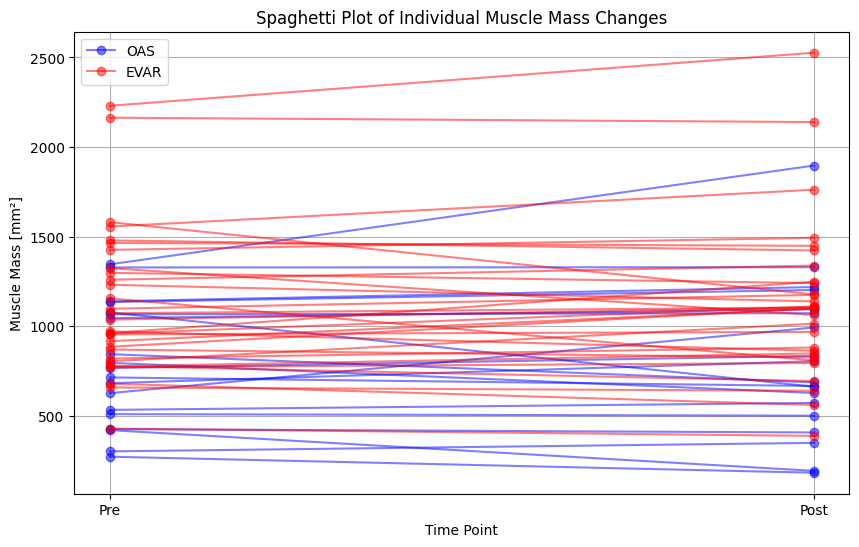

In [86]:
# スパゲッティプロットの作成
plt.figure(figsize=(10, 6))

# 各個人のmass_preとmass_postの変化をプロット（OAS群）
plt.plot([], [], marker='o', color='blue', alpha=0.5, label='OAS')  # ラベル用のダミープロット
for _, row in post_data[post_data['EVAR'] == 0].iterrows():
    plt.plot(['Pre', 'Post'], [row['mass_pre'], row['mass_post']], marker='o', color='blue', alpha=0.5)

# 各個人のmass_preとmass_postの変化をプロット（EVAR群）
plt.plot([], [], marker='o', color='red', alpha=0.5, label='EVAR')  # ラベル用のダミープロット
for _, row in post_data[post_data['EVAR'] == 1].iterrows():
    plt.plot(['Pre', 'Post'], [row['mass_pre'], row['mass_post']], marker='o', color='red', alpha=0.5)

# Open Surgery Group（OAS） の平均値を計算
open_surgery_pre_mean = post_data[post_data['EVAR'] == 0]['mass_pre'].mean()
open_surgery_post_mean = post_data[post_data['EVAR'] == 0]['mass_post'].mean()

# EVAR Group の平均値を計算
evar_pre_mean = post_data[post_data['EVAR'] == 1]['mass_pre'].mean()
evar_post_mean = post_data[post_data['EVAR'] == 1]['mass_post'].mean()

# プロットの装飾
plt.xlabel('Time Point')
plt.ylabel('Muscle Mass [mm²]')
plt.title('Spaghetti Plot of Individual Muscle Mass Changes')

# 凡例の追加
plt.legend()
plt.grid(True)

# プロットの表示
plt.show()

C:\Users\bougt\AppData\Local\Temp\ipykernel_49256\429600487.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'95% CI: [{conf_int_tiva[0][2]:.2f}, {conf_int_tiva[1][2]:.2f}]\n'


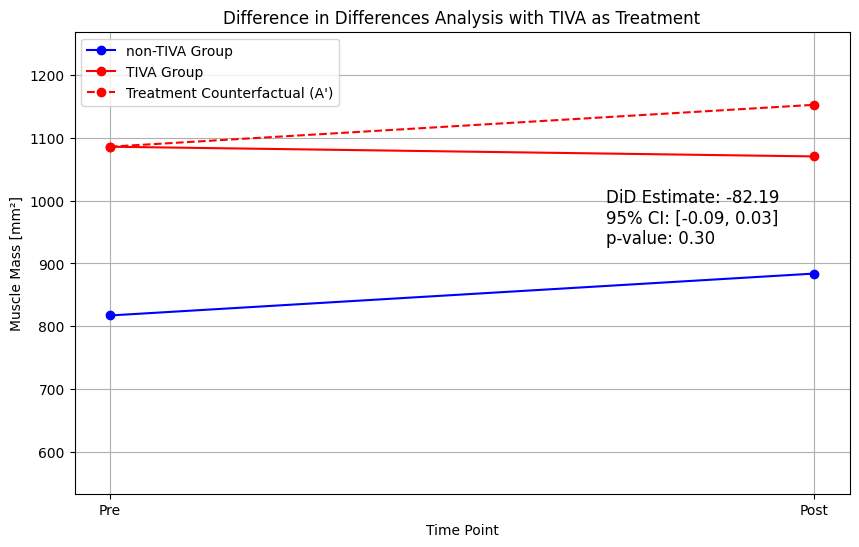

In [25]:
# Redefining the intervention to TIVA for the DID analysis

# Update the treatment indicator to TIVA
post_data['treatment'] = post_data['TIVA']

# Recalculate group averages for pre and post intervention
control_pre = post_data[post_data['treatment'] == 0]['mass_pre'].mean()
control_post = post_data[post_data['treatment'] == 0]['mass_post'].mean()
treatment_pre = post_data[post_data['treatment'] == 1]['mass_pre'].mean()
treatment_post = post_data[post_data['treatment'] == 1]['mass_post'].mean()

# Calculate the differences for control and treatment groups
control_diff = control_post - control_pre
treatment_diff = treatment_post - treatment_pre

# Calculate the Difference in Differences estimate
did_estimate = treatment_diff - control_diff

# Run the DID regression model with the new treatment indicator
post_data['treatment_x_post'] = post_data['treatment'] * post_data['post_period']
did_model_tiva = sm.OLS(post_data['mass_change'], sm.add_constant(post_data[['treatment', 'post_period', 'treatment_x_post']]))
did_results_tiva = did_model_tiva.fit()

# Get the coefficients and stats for the new model
coefficients_tiva = did_results_tiva.params
conf_int_tiva = did_results_tiva.conf_int()
t_stat_tiva = did_results_tiva.tvalues['treatment_x_post']
p_value_tiva = did_results_tiva.pvalues['treatment_x_post']

# Calculate the counterfactual for the treatment group (what would have happened without TIVA treatment)
counterfactual_treatment_post_tiva = treatment_pre + control_diff

# non-TIVA Groupのmass_preの第1四分位点（Q1）を取得
non_tiva_q1 = post_data[post_data['treatment'] == 0]['mass_pre'].quantile(0.25)

# TIVA Groupのmass_preの第3四分位点（Q3）を取得
tiva_q3 = post_data[post_data['treatment'] == 1]['mass_pre'].quantile(0.75)

# プロットの作成
plt.figure(figsize=(10, 6))

# 実測値のプロット
plt.plot(['Pre', 'Post'], [control_pre, control_post], 'o-', label='non-TIVA Group', color='blue')
plt.plot(['Pre', 'Post'], [treatment_pre, treatment_post], 'o-', label='TIVA Group', color='red')

# カウンターファクチュアルのプロット
plt.plot(['Pre', 'Post'], [treatment_pre, counterfactual_treatment_post_tiva], 'o--', label='Treatment Counterfactual (A\')', color='red')

# 注釈の追加

annotation_text = (f'DiD Estimate: {did_estimate:.2f}\n'
                   f'95% CI: [{conf_int_tiva[0][2]:.2f}, {conf_int_tiva[1][2]:.2f}]\n'
                   f'p-value: {p_value_tiva:.2f}')
plt.annotate(annotation_text, xy=(1, counterfactual_treatment_post_tiva), xycoords='data',
             xytext=(-150, -100), textcoords='offset points', fontsize=12)


# y軸の範囲を設定（non-TIVA群のQ1からTIVA群のQ3まで）
plt.ylim(non_tiva_q1, tiva_q3)

# プロットの装飾
plt.xlabel('Time Point')
plt.ylabel('Muscle Mass [mm\u00B2]')
plt.title('Difference in Differences Analysis with TIVA as Treatment')
plt.legend()
plt.grid(True)

# プロットの表示
plt.show()

# ↑TIVAが不利だが有意ではない（EVARとの交絡あり）

C:\Users\bougt\AppData\Local\Temp\ipykernel_49256\3649564253.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'95% CI: [{conf_int_tiva[0][2]:.2f}, {conf_int_tiva[1][2]:.2f}]\n'


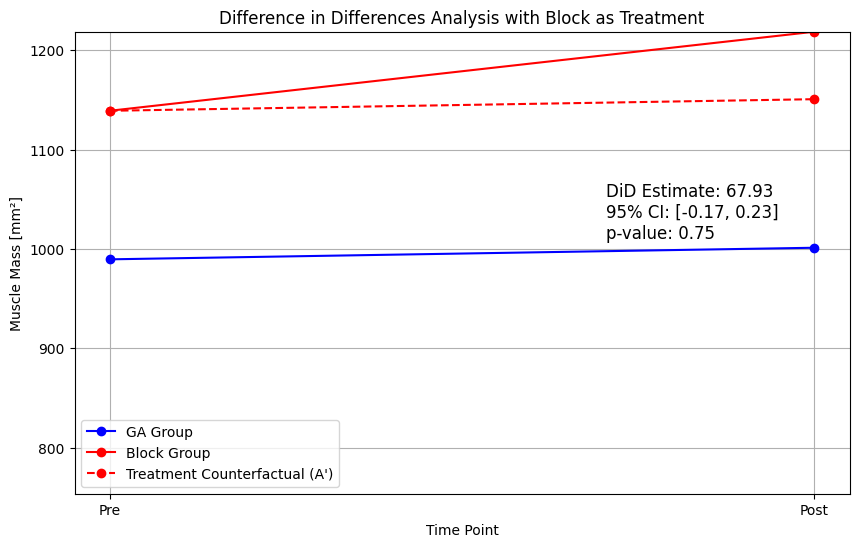

In [41]:
# Redefining the intervention to TIVA for the DID analysis

# Update the treatment indicator to TIVA
post_data['treatment'] = post_data['Block']

# Recalculate group averages for pre and post intervention
control_pre = post_data[post_data['treatment'] == 0]['mass_pre'].mean()
control_post = post_data[post_data['treatment'] == 0]['mass_post'].mean()
treatment_pre = post_data[post_data['treatment'] == 1]['mass_pre'].mean()
treatment_post = post_data[post_data['treatment'] == 1]['mass_post'].mean()

# Calculate the differences for control and treatment groups
control_diff = control_post - control_pre
treatment_diff = treatment_post - treatment_pre

# Calculate the Difference in Differences estimate
did_estimate = treatment_diff - control_diff

# Run the DID regression model with the new treatment indicator
post_data['treatment_x_post'] = post_data['treatment'] * post_data['post_period']
did_model_tiva = sm.OLS(post_data['mass_change'], sm.add_constant(post_data[['treatment', 'post_period', 'treatment_x_post']]))
did_results_tiva = did_model_tiva.fit()

# Get the coefficients and stats for the new model
coefficients_tiva = did_results_tiva.params
conf_int_tiva = did_results_tiva.conf_int()
t_stat_tiva = did_results_tiva.tvalues['treatment_x_post']
p_value_tiva = did_results_tiva.pvalues['treatment_x_post']

# Calculate the counterfactual for the treatment group (what would have happened without TIVA treatment)
counterfactual_treatment_post_tiva = treatment_pre + control_diff

# non-TIVA Groupのmass_preの第1四分位点（Q1）を取得
non_tiva_q1 = post_data[post_data['treatment'] == 0]['mass_pre'].quantile(0.25)

# TIVA Groupのmass_preの第3四分位点（Q3）を取得
tiva_q3 = post_data[post_data['treatment'] == 1]['mass_post'].quantile(0.75)

# Create the plot for TIVA
plt.figure(figsize=(10, 6))

# Plot the actual averages
plt.plot(['Pre', 'Post'], [control_pre, control_post], 'o-', label='GA Group', color='blue')
plt.plot(['Pre', 'Post'], [treatment_pre, treatment_post], 'o-', label='Block Group', color='red')

# Plot the counterfactual line
plt.plot(['Pre', 'Post'], [treatment_pre, counterfactual_treatment_post_tiva], 'o--', label='Treatment Counterfactual (A\')', color='red')

# Annotate the DiD estimate
annotation_text = (f'DiD Estimate: {did_estimate:.2f}\n'
                   f'95% CI: [{conf_int_tiva[0][2]:.2f}, {conf_int_tiva[1][2]:.2f}]\n'
                   f'p-value: {p_value_tiva:.2f}')

plt.annotate(annotation_text, xy=(1, counterfactual_treatment_post_tiva), xycoords='data',
             xytext=(-150, -100), textcoords='offset points', fontsize=12)

# y軸の範囲を設定（non-TIVA群のQ1からTIVA群のQ3まで）
plt.ylim(non_tiva_q1, tiva_q3)

plt.xlabel('Time Point')
plt.ylabel('Muscle Mass [mm\u00B2]')
plt.title('Difference in Differences Analysis with Block as Treatment')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# blockが有利だが有意ではない

treatment
0   -0.005364
1    0.013901
Name: change_rate, dtype: float64 -0.33225909268577986 0.7411709483001513


C:\Users\bougt\AppData\Local\Temp\ipykernel_49256\1738562806.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_change_rates, treatment_change_rates], labels=['OAS', 'EVAR'])


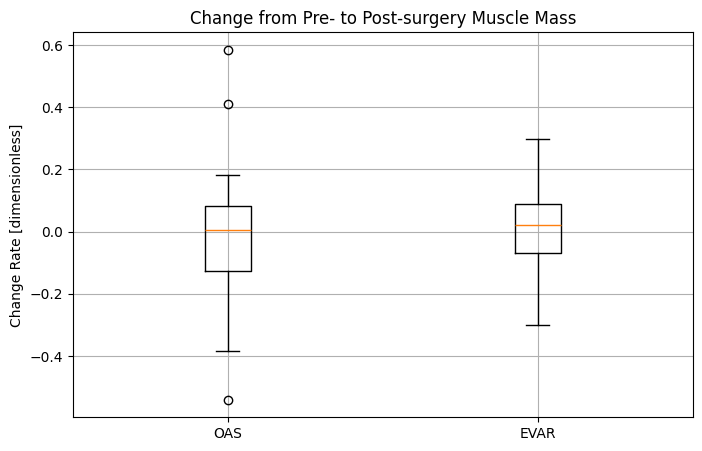

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# データの読み込み
data = pd.read_excel('D:/from_689/AAA_2023_DID_PSM_mod.xlsx', sheet_name='post (2)')
data = data[data['mass_post']!=0]

# Recalculating treatment for EVAR
data['treatment'] = data['EVAR']

# Calculating the change rates for mass from pre to post
data['change_rate'] = (data['mass_post'] - data['mass_pre']) / data['mass_pre']

# Group by treatment and calculate the average change rate for each group
change_rate_by_group = data.groupby('treatment')['change_rate'].mean()

# Group data for t-test
control_group = data[data['treatment'] == 0]['change_rate']
treatment_group = data[data['treatment'] == 1]['change_rate']

# Perform t-test
t_stat, p_value = stats.ttest_ind(control_group, treatment_group)

print(change_rate_by_group, t_stat, p_value)

# Prepare data for visualization
control_change_rates = data[data['treatment'] == 0]['change_rate']
treatment_change_rates = data[data['treatment'] == 1]['change_rate']

# Create a boxplot to visualize the change rates
plt.figure(figsize=(8, 5))
plt.boxplot([control_change_rates, treatment_change_rates], labels=['OAS', 'EVAR'])
plt.title('Change from Pre- to Post-surgery Muscle Mass')
plt.ylabel('Change Rate [dimensionless]')
plt.grid(True)

# Adding t-test results as annotation
#plt.annotate(f't-statistic: {t_stat:.2f}\np-value: {p_value:.2f}', 
#             xy=(1, max(max(control_change_rates), max(treatment_change_rates))), 
#             xytext=(1.1, max(max(control_change_rates), max(treatment_change_rates))), 
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

plt.show()


C:\Users\bougt\AppData\Local\Temp\ipykernel_49256\4154573739.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_change_rates, treatment_change_rates], labels=['OAS', 'EVAR'])


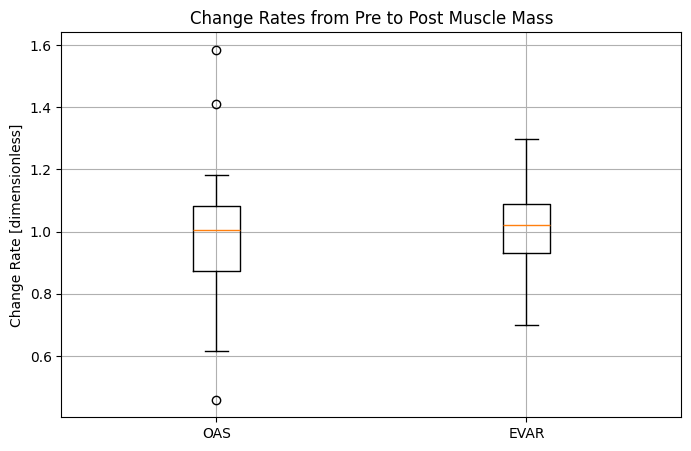

In [56]:
# Re-import necessary libraries for visualization
import matplotlib.pyplot as plt

# Perform a t-test to compare the means of the two independent samples
from scipy import stats

# Recalculating treatment for EVAR
post_data['treatment'] = post_data['EVAR']

# Calculating the change rates for mass from pre to post
post_data['change_rate'] = post_data['mass_post']  / post_data['mass_pre']

# Group by treatment and calculate the average change rate for each group
change_rate_by_group = post_data.groupby('treatment')['change_rate'].mean()

t_stat, p_value = stats.ttest_ind(control_group, treatment_group)

change_rate_by_group, t_stat, p_value

# Prepare data for visualization
control_change_rates = post_data[post_data['treatment'] == 0]['change_rate']
treatment_change_rates = post_data[post_data['treatment'] == 1]['change_rate']

# Create a boxplot to visualize the change rates
plt.figure(figsize=(8, 5))
plt.boxplot([control_change_rates, treatment_change_rates], labels=['OAS', 'EVAR'])
plt.title('Change Rates from Pre to Post Muscle Mass')
plt.ylabel('Change Rate [dimensionless]')
plt.grid(True)
plt.show()

In [58]:
# Since the statsmodels does not have tost_ind, we'll perform the TOST manually using scipy's ttest_ind function.
# Re-importing the necessary libraries
import numpy as np
from scipy.stats import ttest_ind

# Re-calculate the treatment for EVAR and the change rates for mass from pre to post
post_data['treatment'] = post_data['EVAR']
post_data['change_rate'] = (post_data['mass_post'] - post_data['mass_pre']) / post_data['mass_pre']

# Separate the change rates into control and treatment groups
control_group = post_data[post_data['treatment'] == 0]['change_rate']
treatment_group = post_data[post_data['treatment'] == 1]['change_rate']

# Define the equivalence margins as ±10% change
eq_margin = 0.1  # 10%

# Conduct TOST
# Lower bound test (control - treatment > -eq_margin)
t_stat_lower, p_value_lower = ttest_ind(control_group, treatment_group, alternative='greater')
p_value_lower /= 2  # Adjust p-value for one-tailed test

# Upper bound test (treatment - control > -eq_margin)
t_stat_upper, p_value_upper = ttest_ind(treatment_group, control_group, alternative='greater')
p_value_upper /= 2  # Adjust p-value for one-tailed test

# Check if both p-values are below the significance level of 0.10 for the equivalence test
equivalence = p_value_lower < 0.10 and p_value_upper < 0.10

equivalence, p_value_lower, p_value_upper

(np.False_, np.float64(0.3147072629249622), np.float64(0.18529273707503782))

同等性検定の結果、以下の結果を得ました：

下限に対する片側検定のp値は約0.314です。
上限に対する片側検定のp値は約0.185です。
この場合、許容される10%の有意水準で両方の片側検定のp値が有意である必要があります。上限の検定のp値は0.10以下ですが、下限の検定のp値は0.10を超えているため、両方の条件を満たしていないため、同等であるという結論を得ることはできません。

したがって、EVARの介入が筋肉量に与える影響は統計的に同等である（つまり、影響がないと同等である）とは言えないという結果になります。この結果は、設定された同等性の限界内での変化が確認できなかったことを意味します

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 0 to 49
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   operation date       49 non-null     datetime64[ns]
 1   male                 49 non-null     int64         
 2   dead                 49 non-null     int64         
 3   age                  49 non-null     int64         
 4   height               49 non-null     float64       
 5   weight               49 non-null     float64       
 6   BMI                  49 non-null     float64       
 7   EVAR                 49 non-null     int64         
 8   TIVA                 49 non-null     int64         
 9   Block                49 non-null     int64         
 10  room duration        49 non-null     int64         
 11  anesthesia duration  49 non-null     int64         
 12  operation duration   49 non-null     int64         
 13  HT                   49 non-null     int64

In [62]:
data.columns

Index(['operation date', 'male', 'dead', 'age', 'height', 'weight', 'BMI',
       'EVAR', 'TIVA', 'Block', 'room duration', 'anesthesia duration',
       'operation duration', 'HT', 'DM', 'DL', 'smoke', 'OMI', 'BA', 'RA',
       'CKD', 'COPD', 'CerebralStroke', 'pre_u_r', 'pre_u_l', 'pre_l_r',
       'pre_l_l', 'post1_u_r', 'post1_u_l', 'post1_l_r', 'post1_l_l',
       'mass_pre', 'post3_u_r', 'post3_u_l', 'post3_l_r', 'post3_l_l',
       'post4_u_r', 'post4_u_l', 'post4_l_r', 'post4_l_l', 'mass_post',
       'treatment', 'change_rate'],
      dtype='object')

In [64]:
from tableone import TableOne

data = data

# 変数リスト（調べたい変数の名前）
columns = ['age', 'male', 'height', 'weight', 'BMI',
           'EVAR', 'TIVA', 'Block', 
           'HT', 'DM', 'DL', 'smoke', 'OMI', 'BA', 'RA', 'CKD', 'COPD', 'CerebralStroke',
           'room duration', 'anesthesia duration', 'operation duration', 
          ]

# カテゴリー変数リスト（カテゴリー変数の名前）
categorical = ['male', 'TIVA', 'Block', 
               'HT', 'DM', 'DL', 'smoke', 'OMI', 'BA', 'RA', 'CKD', 'COPD', 'CerebralStroke',
              ]

# グループ化のための変数（比較したいグループがあれば）
groupby = 'EVAR'

# 非正規分布変数リスト（非正規分布の連続変数の名前）
nonnormal = [
            ]

# Table 1 の作成
table_one = TableOne(data, columns=columns, categorical=categorical, groupby=groupby, nonnormal=nonnormal, pval=True, htest_name=True, overall = False)
table_one.to_excel('aaa_muscle_table.xlsx')

# Table 1 の表示
table_one

Grouped by EVAR                                                       
                                         Missing             0             1 P-Value               Test
n                                                           19            30                           
age, mean (SD)                                 0    70.6 (9.8)    72.1 (7.8)   0.585  Two Sample T-test
male, n (%)                    0                      5 (26.3)      3 (10.0)   0.233     Fisher's exact
                               1                     14 (73.7)     27 (90.0)                           
height, mean (SD)                              0   162.1 (5.8)   161.7 (9.1)   0.832  Two Sample T-test
weight, mean (SD)                              0   58.9 (11.2)   63.6 (11.8)   0.166  Two Sample T-test
BMI, mean (SD)                                 0    22.3 (3.7)    24.2 (3.5)   0.079  Two Sample T-test
TIVA, n (%)                    0                     15 (78.9)       2 (6.7)  <0.001        Chi-squared
                               1                      4 (21.1)     28 (93.3)                           
Block, n (%)                   0                     18 (94.7)    30 (100.0)   0.388     Fisher's exact
                               1                       1 (5.3)                                         
HT, n (%)                      0                      8 (42.1)      6 (20.0)   0.179        Chi-squared
                               1                     11 (57.9)     24 (80.0)                           
DM, n (%)                      0                     16 (84.2)     23 (76.7)   0.720     Fisher's exact
                               1                      3 (15.8)      7 (23.3)                           
DL, n (%)                      0                     11 (57.9)     20 (66.7)   0.752        Chi-squared
                               1                      8 (42.1)     10 (33.3)                           
smoke, n (%)                   0                     15 (78.9)     23 (76.7)   1.000     Fisher's exact
                               1                      4 (21.1)      7 (23.3)                           
OMI, n (%)                     0                     16 (84.2)     25 (83.3)   1.000     Fisher's exact
                               1                      3 (15.8)      5 (16.7)                           
BA, n (%)                      0                     17 (89.5)    30 (100.0)   0.145     Fisher's exact
                               1                      2 (10.5)                                         
RA, n (%)                      0                    19 (100.0)     28 (93.3)   0.515     Fisher's exact
                               1                                     2 (6.7)                           
CKD, n (%)                     0                     17 (89.5)     26 (86.7)   1.000     Fisher's exact
                               1                      2 (10.5)      4 (13.3)                           
COPD, n (%)                    0                     17 (89.5)     25 (83.3)   0.691     Fisher's exact
                               1                      2 (10.5)      5 (16.7)                           
CerebralStroke, n (%)          0                     18 (94.7)     26 (86.7)   0.636     Fisher's exact
                               1                       1 (5.3)      4 (13.3)                           
room duration, mean (SD)                       0  365.2 (85.1)  264.9 (58.9)  <0.001  Two Sample T-test
anesthesia duration, mean (SD)                 0  350.5 (83.6)  230.5 (52.1)  <0.001  Two Sample T-test
operation duration, mean (SD)                  0  270.9 (78.1)  152.3 (54.6)  <0.001  Two Sample T-test

In [66]:
# Calculate the 'change' column as specified
post_data['change'] = post_data['mass_post'] / post_data['mass_pre']

# Display the first few rows to confirm the 'change' column has been added correctly
post_data

,operation date,male,dead,age,height,weight,BMI,EVAR,TIVA,Block,...,post4_u_l,post4_l_r,post4_l_l,mass_post,treatment,post_period,mass_change,treatment_x_post,change_rate,change
0,2012-03-16,1,0,71,156.0,71.15,29.24,0,0,0,...,12.54,14.76,22.86,1093.99,0,1,1.046910,0,0.046910,1.046910
1,2012-07-12,1,0,66,167.8,78.50,27.88,1,1,0,...,17.05,18.81,18.82,1177.45,1,1,0.744877,0,-0.255123,0.744877
2,2012-07-26,1,0,68,170.6,70.40,24.19,0,0,0,...,14.10,19.12,20.48,1329.33,0,1,1.000964,0,0.000964,1.000964
3,2012-08-30,1,1,80,162.2,49.00,18.62,0,1,0,...,7.96,15.54,16.48,501.18,0,1,0.983419,0,-0.016581,0.983419
4,2012-09-06,0,0,66,157.5,47.00,18.95,0,0,0,...,10.85,21.07,20.12,805.36,0,1,1.180620,0,0.180620,1.180620
5,2012-09-13,1,0,59,166.3,66.90,24.19,0,0,0,...,11.84,18.38,22.73,1202.45,0,1,1.059530,0,0.059530,1.059530
6,2012-10-04,1,0,71,165.5,58.20,21.25,1,1,0,...,11.70,18.44,20.56,825.82,1,1,0.949229,0,-0.050771,0.949229
7,2012-11-08,1,0,75,158.5,56.70,22.57,1,1,0,...,11.37,18.08,19.01,863.47,1,1,0.889387,0,-0.110613,0.889387
8,2012-11-12,1,0,82,165.0,66.00,24.24,0,0,0,...,8.27,22.20,19.29,666.74,0,1,0.933300,0,-0.066700,0.933300
9,2012-12-06,1,0,59,161.0,64.30,24.81,1,1,0,...,17.13,24.01,24.48,1761.64,1,1,1.132116,0,0.132116,1.132116


# 高齢者ではどうなの？

C:\Users\bougt\AppData\Local\Temp\ipykernel_49256\3819629784.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'95% CI: [{conf_int[0][2]:.2f}, {conf_int[1][2]:.2f}]\n'


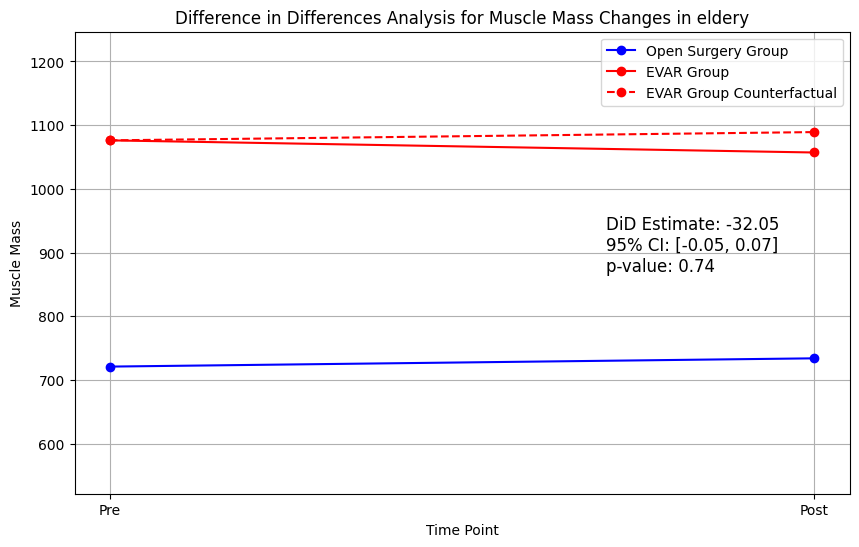

In [68]:
post_data_ = post_data.copy()
post_data_ = post_data[post_data['age']>=65]

# Calculate group averages for pre and post intervention
control_pre = post_data_[post_data_['treatment'] == 0]['mass_pre'].mean()
control_post = post_data_[post_data_['treatment'] == 0]['mass_post'].mean()
treatment_pre = post_data_[post_data_['treatment'] == 1]['mass_pre'].mean()
treatment_post = post_data_[post_data_['treatment'] == 1]['mass_post'].mean()

# Calculate the differences for control and treatment groups
control_diff = control_post - control_pre
treatment_diff = treatment_post - treatment_pre

# Calculate the Difference in Differences estimate
did_estimate = treatment_diff - control_diff

# Get the coefficients from the DID model
coefficients = did_results.params
conf_int = did_results.conf_int()
t_stat = did_results.tvalues['treatment_x_post']
p_value = did_results.pvalues['treatment_x_post']

# Calculate the counterfactual for the treatment group (what would have happened without treatment)
counterfactual_treatment_post = treatment_pre + control_diff

# non-TIVA Groupのmass_preの第1四分位点（Q1）を取得
non_tiva_q1 = post_data[post_data['treatment'] == 0]['mass_pre'].quantile(0.25)

# TIVA Groupのmass_preの第3四分位点（Q3）を取得
tiva_q3 = post_data[post_data['treatment'] == 1]['mass_post'].quantile(0.75)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the actual averages
plt.plot(['Pre', 'Post'], [control_pre, control_post], 'o-', label='Open Surgery Group', color='blue')
plt.plot(['Pre', 'Post'], [treatment_pre, treatment_post], 'o-', label='EVAR Group', color='red')

# Plot the counterfactual line
plt.plot(['Pre', 'Post'], [treatment_pre, counterfactual_treatment_post], 'o--', label='EVAR Group Counterfactual', color='red')

# Annotate the DiD estimate
annotation_text = (f'DiD Estimate: {did_estimate:.2f}\n'
                   f'95% CI: [{conf_int[0][2]:.2f}, {conf_int[1][2]:.2f}]\n'
                   f'p-value: {p_value:.2f}')

plt.annotate(annotation_text, xy=(1, counterfactual_treatment_post), xycoords='data',
             xytext=(-150, -100), textcoords='offset points', fontsize=12)

# y軸の範囲を設定（non-TIVA群のQ1からTIVA群のQ3まで）
plt.ylim(non_tiva_q1, tiva_q3)

plt.xlabel('Time Point')
plt.ylabel('Muscle Mass')
plt.title('Difference in Differences Analysis for Muscle Mass Changes in eldery')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# 高齢者でもかわらないよ

In [70]:
# Since the statsmodels does not have tost_ind, we'll perform the TOST manually using scipy's ttest_ind function.
# Re-importing the necessary libraries
import numpy as np
from scipy.stats import ttest_ind

# Re-calculate the treatment for EVAR and the change rates for mass from pre to post
post_data_['treatment'] = post_data_['EVAR']
post_data_['change_rate'] = (post_data_['mass_post'] - post_data_['mass_pre']) / post_data_['mass_pre']

# Separate the change rates into control and treatment groups
control_group = post_data_[post_data_['treatment'] == 0]['change_rate']
treatment_group = post_data_[post_data_['treatment'] == 1]['change_rate']

# Define the equivalence margins as ±10% change
eq_margin = 0.1  # 10%

# Conduct TOST
# Lower bound test (control - treatment > -eq_margin)
t_stat_lower, p_value_lower = ttest_ind(control_group, treatment_group, alternative='greater')
p_value_lower /= 2  # Adjust p-value for one-tailed test

# Upper bound test (treatment - control > -eq_margin)
t_stat_upper, p_value_upper = ttest_ind(treatment_group, control_group, alternative='greater')
p_value_upper /= 2  # Adjust p-value for one-tailed test

# Check if both p-values are below the significance level of 0.10 for the equivalence test
equivalence = p_value_lower < 0.10 and p_value_upper < 0.10

equivalence, p_value_lower, p_value_upper

C:\Users\bougt\AppData\Local\Temp\ipykernel_49256\170843114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data_['treatment'] = post_data_['EVAR']
C:\Users\bougt\AppData\Local\Temp\ipykernel_49256\170843114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data_['change_rate'] = (post_data_['mass_post'] - post_data_['mass_pre']) / post_data_['mass_pre']


(np.False_, np.float64(0.2359594648929127), np.float64(0.2640405351070873))

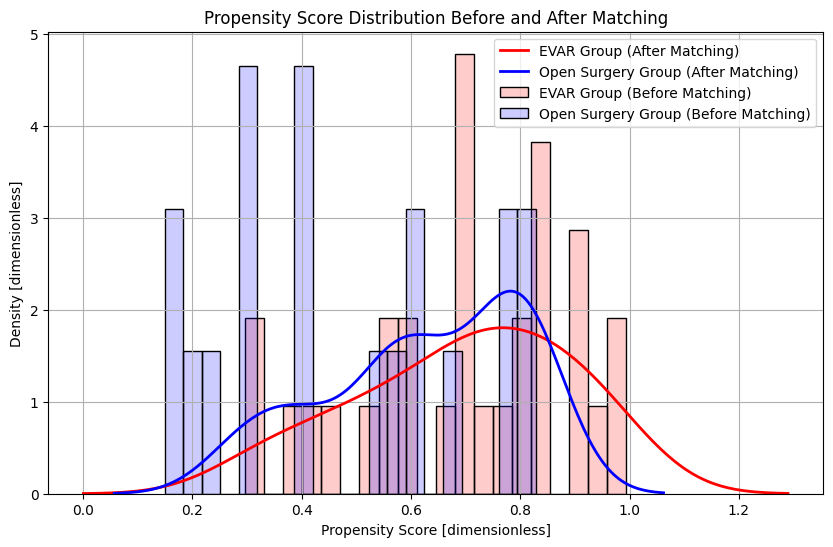

In [72]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# post_periodの作成
data['post_period'] = (~data[['post4_u_r', 'post4_u_l', 'post4_l_r', 'post4_l_l']].isnull().all(axis=1)).astype(int)

# データのクリーニング
data_clean = data.dropna(subset=['male', 'age', 'BMI', 'mass_pre'])

# 傾向スコアの算出
model = LogisticRegression()
model.fit(data_clean[['male', 'age', 'BMI', 'mass_pre']], data_clean['EVAR'])
data_clean['propensity_score'] = model.predict_proba(data_clean[['male', 'age', 'BMI', 'mass_pre']])[:,1]

# キャリパーの設定
caliper = 0.05

# マッチングの実施
treated = data_clean[data_clean['EVAR'] == 1]
control = data_clean[data_clean['EVAR'] == 0]

# Nearest Neighborsマッチングの準備
nn = NearestNeighbors(radius=caliper)
nn.fit(control[['propensity_score']])
distances, indices = nn.radius_neighbors(treated[['propensity_score']])

# マッチングされたデータの抽出
matched_indices = [ind for sublist in indices for ind in sublist]
matched_control = control.iloc[matched_indices]

# マッチング後のデータセットの作成
matched_data = pd.concat([treated, matched_control])

# ヒストグラムとKDEのプロット作成
plt.figure(figsize=(10, 6))

# マッチング前のヒストグラム
sns.histplot(data_clean[data_clean['EVAR'] == 1]['propensity_score'], color='red', label='EVAR Group (Before Matching)', stat="density", bins=20, kde=False, alpha=0.2)
sns.histplot(data_clean[data_clean['EVAR'] == 0]['propensity_score'], color='blue', label='Open Surgery Group (Before Matching)', stat="density", bins=20, kde=False, alpha=0.2)

# マッチング後のKDE
sns.kdeplot(treated['propensity_score'], color='red', label='EVAR Group (After Matching)', lw=2)
sns.kdeplot(matched_control['propensity_score'], color='blue', label='Open Surgery Group (After Matching)', lw=2)

# プロットの装飾
plt.xlabel('Propensity Score [dimensionless]')
plt.ylabel('Density [dimensionless]')
plt.title('Propensity Score Distribution Before and After Matching')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
# マッチング後のデータセットの再確認と準備
matched_data['post_period'] = (~matched_data[['post4_u_r', 'post4_u_l', 'post4_l_r', 'post4_l_l']].isnull().all(axis=1)).astype(int)
matched_data['mass_change'] = matched_data['mass_post'] / matched_data['mass_pre']
matched_data['treatment'] = matched_data['EVAR']
matched_data['treatment_x_post'] = matched_data['treatment'] * matched_data['post_period']

# DIDモデルの定義と実行
did_model_matched = sm.OLS(matched_data['mass_change'], sm.add_constant(matched_data[['treatment', 'post_period', 'treatment_x_post']]))
did_results_matched = did_model_matched.fit()

# モデルの結果の表示
did_results_matched.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mass_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.08185
Date:                Sun, 06 Oct 2024   Prob (F-statistic):              0.775
Time:                        21:36:05   Log-Likelihood:                 15.124
No. Observations:                  88   AIC:                            -26.25
Df Residuals:                      86   BIC:                            -21.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
treatment            0.0066      0.023      0.286      0.775      -0.039       0.053
post_period          1.0006      0.027     36.972      0.000       0.947       1.054
treatment_x_post     0.0066      0.023      0.286      0.775      -0.039       0.053
==============================================================================
Omnibus:                        4.913   Durbin-Watson:                   2.375
Prob(Omnibus):                  0.086   Jarque-Bera (JB):                6.623
Skew:                           0.085   Prob(JB):                       0.0365
Kurtosis:                       4.333   Cond. No.                     4.46e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.97e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [76]:
# 欠損値の確認
missing_values_summary = matched_data.isnull().sum()
missing_values_summary


operation date         0
male                   0
dead                   0
age                    0
height                 0
weight                 0
BMI                    0
EVAR                   0
TIVA                   0
Block                  0
room duration          0
anesthesia duration    0
operation duration     0
HT                     0
DM                     0
DL                     0
smoke                  0
OMI                    0
BA                     0
RA                     0
CKD                    0
COPD                   0
CerebralStroke         0
pre_u_r                0
pre_u_l                0
pre_l_r                0
pre_l_l                0
post1_u_r              0
post1_u_l              0
post1_l_r              0
post1_l_l              0
mass_pre               0
post3_u_r              0
post3_u_l              0
post3_l_r              0
post3_l_l              0
post4_u_r              0
post4_u_l              0
post4_l_r              0
post4_l_l              0


In [78]:
# 欠損値の削除
clean_matched_data = matched_data.dropna(subset=['mass_post', 'mass_change'])

# DIDモデルの定義と実行
did_model_clean_matched = sm.OLS(clean_matched_data['mass_change'], sm.add_constant(clean_matched_data[['treatment', 'post_period', 'treatment_x_post']]))
did_results_clean_matched = did_model_clean_matched.fit()

# モデルの結果の表示
print(did_results_clean_matched.summary())


                            OLS Regression Results                            
Dep. Variable:            mass_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.08185
Date:                Sun, 06 Oct 2024   Prob (F-statistic):              0.775
Time:                        21:36:07   Log-Likelihood:                 15.124
No. Observations:                  88   AIC:                            -26.25
Df Residuals:                      86   BIC:                            -21.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
treatment            0.0066      0.023  

In [80]:
did_estimate = did_results_clean_matched.params["treatment_x_post"]
did_conf_int = did_results_clean_matched.conf_int().loc["treatment_x_post"]
did_t_value = did_results_clean_matched.tvalues["treatment_x_post"]
did_p_value = did_results_clean_matched.pvalues["treatment_x_post"]

did_effect = {
    'DID Estimate': did_estimate,
    '95% CI': [did_conf_int[0], did_conf_int[1]],
    't-value': did_t_value,
    'p-value': did_p_value
}

print(did_effect)


{'DID Estimate': np.float64(0.006630726917436109), '95% CI': [np.float64(-0.03944335204327968), np.float64(0.0527048058781519)], 't-value': np.float64(0.286092509036154), 'p-value': np.float64(0.7754952878776203)}


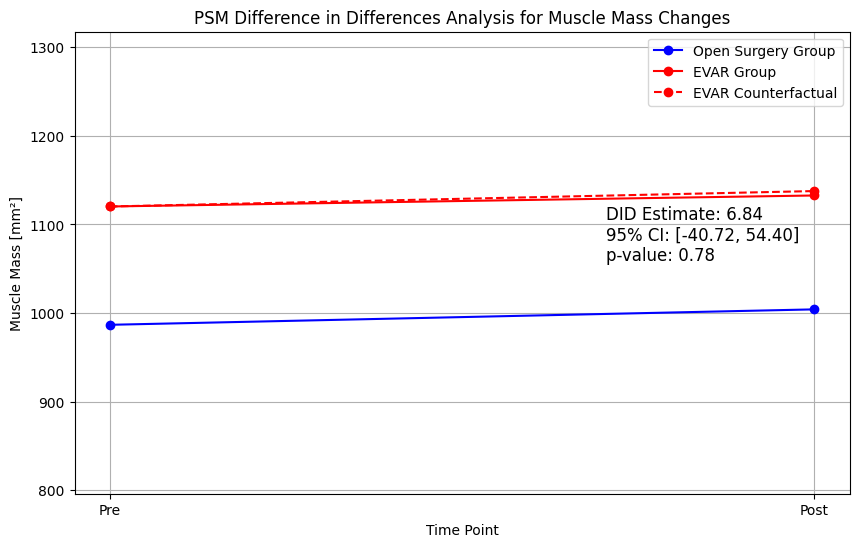

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Open Surgery Group の平均値を計算
open_surgery_pre_mean = clean_matched_data[clean_matched_data['EVAR'] == 0]['mass_pre'].mean()
open_surgery_post_mean = clean_matched_data[clean_matched_data['EVAR'] == 0]['mass_post'].mean()

# EVAR Group の平均値を計算
evar_pre_mean = clean_matched_data[clean_matched_data['EVAR'] == 1]['mass_pre'].mean()
evar_post_mean = clean_matched_data[clean_matched_data['EVAR'] == 1]['mass_post'].mean()

# Counterfactual for EVAR (Open Surgery Groupと並行)
evar_counterfactual_pre = evar_pre_mean
evar_counterfactual_post = evar_pre_mean + (open_surgery_post_mean - open_surgery_pre_mean)

# モデルから得られた DiD 推定値
did_estimate_raw = did_results_clean_matched.params["treatment_x_post"]

# 各個人の mass_pre に対する調整を行う
# DiD推定値を個々のpre値を基準にしてmassの単位に変換する
mass_adjustment_factor = clean_matched_data['mass_pre'].mean()  # 補正係数として mass_pre の平均を使用
did_estimate_adjusted = did_estimate_raw * mass_adjustment_factor

# 信頼区間の調整
did_conf_int = did_results_clean_matched.conf_int().loc["treatment_x_post"]
did_conf_int_adjusted = [conf * mass_adjustment_factor for conf in did_conf_int]

# p-valueとt値はそのまま表示
did_p_value = did_results_clean_matched.pvalues["treatment_x_post"]

# OAS群（EVAR=0）のmassのQ1を取得
oas_q1 = clean_matched_data[clean_matched_data['EVAR'] == 0]['mass_pre'].quantile(0.25)

# EVAR群（EVAR=1）のmassのQ3を取得
evar_q3 = clean_matched_data[clean_matched_data['EVAR'] == 1]['mass_pre'].quantile(0.75)

# プロットの作成
plt.figure(figsize=(10, 6))

# Open Surgery Group
plt.plot(['Pre', 'Post'], [open_surgery_pre_mean, open_surgery_post_mean], 
         marker='o', color='blue', label='Open Surgery Group')

# EVAR Group
plt.plot(['Pre', 'Post'], [evar_pre_mean, evar_post_mean], 
         marker='o', color='red', label='EVAR Group')

# Counterfactual for EVAR
plt.plot(['Pre', 'Post'], [evar_counterfactual_pre, evar_counterfactual_post], 
         marker='o', linestyle='dashed', color='red', label='EVAR Counterfactual')

# プロットの装飾
plt.xlabel('Time Point')
plt.ylabel('Muscle Mass [mm²]')
plt.title('PSM Difference in Differences Analysis for Muscle Mass Changes')
plt.legend()
plt.grid(True)

# y軸の範囲をOAS群のQ1からEVAR群のQ3に設定
plt.ylim(oas_q1, evar_q3)

# 注釈の追加（矢印と枠線なし）
annotation_text = (f'DID Estimate: {did_estimate_adjusted:.2f}\n'
                   f'95% CI: [{did_conf_int_adjusted[0]:.2f}, {did_conf_int_adjusted[1]:.2f}]\n'
                   f'p-value: {did_p_value:.2f}')
plt.annotate(annotation_text, xy=(1, evar_counterfactual_post), xycoords='data',
             xytext=(-150, -50), textcoords='offset points', fontsize=12)

# プロットの表示
plt.show()
